In [143]:
%matplotlib notebook
import cvxpy as cp
import dccp
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.metrics import zero_one_loss, confusion_matrix
from scipy.io import arff
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.utils import shuffle
import matplotlib.patches as mpatches
import json
import random
import math
import os, psutil
from datetime import datetime
import torch.nn as nn
from torch.autograd import Variable
from torch.autograd.functional import jacobian


torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)

TRAIN_SLOPE = 2
EVAL_SLOPE = 5
X_LOWER_BOUND = -10
X_UPPER_BOUND = 10

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Utils

In [144]:
def split_data(X, Y, percentage):
    num_val = int(len(X)*percentage)
    return X[num_val:], Y[num_val:], X[:num_val], Y[:num_val]

def shuffle(X, Y):
    data = torch.cat((X, Y), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, :2]
    Y = data[:, 2]
    return X, Y

def conf_mat(Y1, Y2):
    num_of_samples = len(Y1)
    mat = confusion_matrix(Y1, Y2, labels=[-1, 1])*100/num_of_samples
    acc = np.trace(mat)
    return mat, acc

def calc_accuracy(Y, Ypred):
    num = len(Y)
    temp = Y - Ypred
    acc = len(temp[temp == 0])*1./num
    return acc

# Dataset

In [145]:
def load_spam_data():
    torch.manual_seed(0)
    np.random.seed(0)
    path = r"C:\Users\sagil\Desktop\nir_project\tip_spam_data\IS_journal_tip_spam.arff"
    data, meta = arff.loadarff(path)
    df = pd.DataFrame(data)
    most_disc = ['qTips_plc', 'rating_plc', 'qEmail_tip', 'qContacts_tip', 'qURL_tip', 'qPhone_tip', 'qNumeriChar_tip', 'sentistrength_tip', 'combined_tip', 'qWords_tip', 'followers_followees_gph', 'qunigram_avg_tip', 'qTips_usr', 'indeg_gph', 'qCapitalChar_tip', 'class1']
    df = df[most_disc]
    df["class1"].replace({b'spam': -1, b'notspam': 1}, inplace=True)
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)

    Y = df['class1'].values
    X = df.drop('class1', axis = 1).values
    x_dim = len(X[0])
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    X /= math.sqrt(x_dim)
    return torch.from_numpy(X), torch.from_numpy(Y)

def load_card_fraud_data():
    torch.manual_seed(0)
    np.random.seed(0)
    df = pd.read_csv('C:/Users/sagil/Desktop/nir_project/card_fraud_dataset/creditcard.csv')

    rob_scaler = RobustScaler()

    df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
    df.drop(['Time','Amount'], axis=1, inplace=True)
    scaled_amount = df['scaled_amount']
    df.drop(['scaled_amount'], axis=1, inplace=True)
    df.insert(0, 'scaled_amount', scaled_amount)

    df["Class"].replace({1: -1, 0: 1}, inplace=True)
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)

    # amount of fraud classes 492 rows.
    fraud_df = df.loc[df['Class'] == -1]
    non_fraud_df = df.loc[df['Class'] == 1][:492]

    normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

    # Shuffle dataframe rows
    df = normal_distributed_df.sample(frac=1, random_state=0).reset_index(drop=True)

    Y = df['Class'].values
    X = df.drop('Class', axis = 1).values
    x_dim = len(X[0])
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    X /= math.sqrt(x_dim)
    return torch.from_numpy(X), torch.from_numpy(Y)

def load_credit_default_data():
    torch.manual_seed(0)
    np.random.seed(0)
    url = 'https://raw.githubusercontent.com/ustunb/actionable-recourse/master/examples/paper/data/credit_processed.csv'
    df = pd.read_csv(url)
    df["NoDefaultNextMonth"].replace({0: -1}, inplace=True)
    df = df.sample(frac=1, random_state=0).reset_index(drop=True)

    df = df.drop(['Married', 'Single', 'Age_lt_25', 'Age_in_25_to_40', 'Age_in_40_to_59', 'Age_geq_60'], axis = 1)

    fraud_df = df.loc[df["NoDefaultNextMonth"] == -1]
    non_fraud_df = df.loc[df["NoDefaultNextMonth"] == 1][:6636]

    normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

    # Shuffle dataframe rows
    df = normal_distributed_df.sample(frac=1, random_state=0).reset_index(drop=True)
    
    scaler = StandardScaler()
    df.loc[:, df.columns != "NoDefaultNextMonth"] = scaler.fit_transform(df.drop("NoDefaultNextMonth", axis=1)) 
    Y, X = df.iloc[:, 0].values, df.iloc[:, 1:].values
    x_dim = len(X[0])
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    X /= math.sqrt(x_dim)
    return torch.from_numpy(X), torch.from_numpy(Y)

def load_financial_distress_data():
    torch.manual_seed(0)
    np.random.seed(0)
    data = pd.read_csv("C:/Users/sagil/Desktop/nir_project/financial_distress_data/Financial Distress.csv")

    data = data[data.columns.drop(list(data.filter(regex='x80')))] # Since it is a categorical feature with 37 features.
    x_dim = len(data.columns) - 3
    data.drop(['Time'], axis=1, inplace=True)

    data_grouped = data.groupby(['Company']).last()

    scaler = StandardScaler()
    data_grouped.loc[:, data_grouped.columns != "Financial Distress"] = scaler.fit_transform(data_grouped.drop("Financial Distress", axis=1))

    # Shuffle dataframe rows
    data_grouped = data_grouped.sample(frac=1, random_state=0).reset_index(drop=True)

    Y, X = data_grouped.iloc[:, 0].values, data_grouped.iloc[:, 1:].values
    for y in range(0,len(Y)): # Coverting target variable from continuous to binary form
        if Y[y] < -0.5:
              Y[y] = -1
        else:
              Y[y] = 1
    x_dim = len(X[0])
    X -= np.mean(X, axis=0)
    X /= np.std(X, axis=0)
    X /= math.sqrt(x_dim)
    return torch.from_numpy(X), torch.from_numpy(Y)

# CCP classes

In [146]:
class CCP:
    def __init__(self, x_dim, h_dim, funcs):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.xt = cp.Parameter(x_dim)
        self.r = cp.Parameter(x_dim)
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1)
        self.slope = cp.Parameter(1)
        

        target = self.x@self.f_derivative(self.xt, self.w, self.b, self.slope)-self.g(self.x, self.w, self.b, self.slope)-self.c(self.x, self.r, x_dim)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
    def ccp(self, r):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.0001 and cnt < 10:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, w, b, B_SPAN, slope):
        """
        tensor to tensor
        """
        X = X.numpy()
        w = w.detach().numpy()
        b = b.detach().numpy()
        slope = np.full(1, slope)
        
        self.w.value = w
        self.b.value = b
        self.slope.value = slope
        
        return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])
    
    
class CCP_MANIFOLD:
    def __init__(self, x_dim, h_dim, funcs):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.v = cp.Variable(h_dim)
        self.xt = cp.Parameter(x_dim)
        self.r = cp.Parameter(x_dim)
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1)
        self.B_span = cp.Parameter((x_dim, h_dim))
        self.slope = cp.Parameter(1)
        

        target = self.x@self.f_derivative(self.xt, self.w, self.b, self.slope)-self.g(self.x, self.w, self.b, self.slope)-self.c(self.x, self.r, x_dim)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND,
                      self.B_span@self.v == self.x-self.r]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
    def ccp(self, r, B_span):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        self.B_span.value = B_span
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.0001 and cnt < 10:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, w, b, B_SPAN, slope):
        """
        tensor to tensor
        """
        X = X.numpy()
        w = w.detach().numpy()
        b = b.detach().numpy()
        B_SPAN = B_SPAN.numpy()
        slope = np.full(1, slope)
        
        self.w.value = w
        self.b.value = b
        self.slope.value = slope
        
        return torch.stack([torch.from_numpy(self.ccp(x, B_span)) for x, B_span in zip(X, B_SPAN)])

In [147]:
class DELTA():
    
    def __init__(self, x_dim, h_dim, funcs):
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))

        target = self.x@self.f_der-self.g(self.x, self.w, self.b, TRAIN_SLOPE)-self.c(self.x, self.r, x_dim)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b, self.f_der],
                                variables=[self.x])
        
        
    def optimize_X(self, X, w, b, F_DER, B_SPAN):
        return self.layer(X, w, b, F_DER)[0]
    
class DELTA_MANIFOLD():
    
    def __init__(self, x_dim, h_dim, funcs):
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.v = cp.Variable(h_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.B_span = cp.Parameter((x_dim, h_dim), value = np.random.randn(x_dim, h_dim))

        target = self.x@self.f_der-self.g(self.x, self.w, self.b, TRAIN_SLOPE)-self.c(self.x, self.r, x_dim)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND,
                      self.B_span@self.v == self.x-self.r]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b, self.f_der, self.B_span],
                                variables=[self.x, self.v])
        
        
    def optimize_X(self, X, w, b, F_DER, B_SPAN):
        return self.layer(X, w, b, F_DER, B_SPAN)[0]

# Gain & Cost functions

In [148]:
def score(x, w, b):
    return x@w + b

def f(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) + 1)]), 2)

def g(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) - 1)]), 2)

def c(x, r, x_dim):
    return cp.sum_squares(x-r)

def f_derivative(x, w, b, slope):
    return 0.5*cp.multiply(slope*((slope*score(x, w, b) + 1)/cp.sqrt((slope*score(x, w, b) + 1)**2 + 1)), w)

funcs = {"f": f, "g": g, "f_derivative": f_derivative, "c": c, "score": score}

# CAE

In [235]:
class CAE(nn.Module):
    def __init__(self, x_dim, h_dim, lamb):
        torch.manual_seed(0)
        np.random.seed(0)
        super(CAE, self).__init__()
        
        self.lamb = lamb
        self.x_dim = x_dim
        self.h_dim = h_dim
        self.fc1 = nn.Linear(x_dim, h_dim, bias = True) # Encoder
#         self.fc2 = nn.Linear(h_dim, h_dim, bias = False)
        self.fc3 = nn.Linear(h_dim, h_dim, bias = False)
        self.fc4 = nn.Linear(h_dim, x_dim, bias = True) # Decoder
        
        self.sigmoid = nn.Sigmoid()

    def encoder(self, x):
        o1 = self.sigmoid(self.fc1(x))
#         o2 = self.sigmoid(self.fc2(o1))
        return self.sigmoid(self.fc3(o1))
    
    def decoder(self, z):
        return self.fc4(z)

    def forward(self, x):
            h1 = self.encoder(x)
            h2 = self.decoder(h1)
            return h1, h2
        
    def get_spans(self, X):
        def func(x):
            return self.forward(x)[0]
        
#         eps = 0.01
        B_SPANS = []
#         All_S = []
        for x in X:
            J = jacobian(func, x)
            U, S, _ = torch.svd(J.T)
#             All_S.append(S)
            B_span = U
#             B_span = U[:, S>eps]
#             if B_span.size()[1] < self.h_dim:
#                 pad = torch.zeros((x_dim, self.h_dim-B_span.size()[1]))
#                 B_span = torch.cat((B_span, pad), 1)
            B_SPANS.append(B_span)
#         All_S = torch.stack(All_S)
#         print("mean of S:", torch.mean(All_S, 0))
#         print("std of S:", torch.std(All_S, 0))
        return torch.stack(B_SPANS)
    
    def contractive_loss(self, x):
        def func(x):
            return self.encoder(x)
        J = jacobian(func, x)
        c_loss = torch.norm(J, 2)**2
#         print("c_loss: ", c_loss)
        return c_loss
    
    def reconstruction_loss(self, x, x_recons):
        mse_loss = nn.MSELoss(size_average = False)
        r_loss = mse_loss(x_recons, x)
#         print("r_loss: ", r_loss)
        return r_loss
        
    def loss(self, x, x_recons, h):
        """Compute the Contractive AutoEncoder Loss
        Evalutes the CAE loss, which is composed as the summation of a Mean
        Squared Error and the weighted l2-norm of the Jacobian of the hidden
        units with respect to the inputs.
        See reference below for an in-depth discussion:
          #1: http://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder
        Args:
            `W` (FloatTensor): (N_hidden x N), where N_hidden and N are the
              dimensions of the hidden units and input respectively.
            `x` (Variable): the input to the network, with dims (N_batch x N)
            recons_x (Variable): the reconstruction of the input, with dims
              N_batch x N.
            `h` (Variable): the hidden units of the network, with dims
              batch_size x N_hidden
            `lam` (float): the weight given to the jacobian regulariser term
        Returns:
            Variable: the (scalar) CAE loss
        """
        r_loss = self.reconstruction_loss(x, x_recons)
        c_loss = self.contractive_loss(x)
        return r_loss + c_loss.mul_(self.lamb)

    def fit(self, X, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False):
        train_dset = TensorDataset(X, torch.ones(len(X)))
        train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        opt = opt(self.parameters(), **opt_kwargs)
        
        for epoch in range(epochs):
            train_loss = 0
            self.train()
            for idx, (Xbatch, _) in enumerate(train_loader):
                Xbatch = Variable(Xbatch)
                opt.zero_grad()

                hidden_representation, recons_x = self.forward(Xbatch)
                l = self.loss(Xbatch, recons_x, hidden_representation)
                
                l.backward()
                train_loss += l.item()
                opt.step()
                
#                 with torch.no_grad():
#                     r_loss = cae.reconstruction_loss(Xbatch, recons_x).item()
#                     c_loss = cae.contractive_loss(Xbatch).item()
#                     print("reconstruction loss: ", r_loss)
#                     print("contractive_loss: ", c_loss)

#                 if idx % 200 and verbose:
#                     print('Train epoch: {} [{}/{}({:.0f}%)]\t Loss: {:.6f}'.format(
#                           epoch, idx*len(Xbatch), len(train_loader.dataset),
#                           100*idx/len(train_loader),
#                           l.item()))
            if verbose:
                print('====> Epoch: {} Average loss: {:.4f}'.format(
                     epoch, train_loss / idx))

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [236]:
EPOCHS = 10
BATCH_SIZE = 128
diff = 0.001
x_dim = len(X_CAE[0])
h_dim = x_dim - 7

X, Y = load_spam_data()
# X, Y = X[:3000], Y[:3000]

X, Y, X_CAE, Y_CAE = split_data(X, Y, 0.5)

cae = CAE(x_dim, h_dim, 1)
cae.fit(X_CAE, opt=torch.optim.Adam, opt_kwargs={"lr": (1e-3)}, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True)

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\torch\nn\_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


====> Epoch: 0 Average loss: 273.4242


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
        Hval, Xval_recons = cae(Xval_CAE)
        r_loss = cae.reconstruction_loss(Xval_CAE, Xval_recons).item()
        c_loss = cae.contractive_loss(Xval).item()
        print("reconstruction loss: ", r_loss)
        print("contractive_loss: ", c_loss)
        print(Xval[0])
        print(Xval_recons[0])

# Delta GD

In [225]:
class DELTA_GD(nn.Module):
    def __init__(self, x_dim, batch_size, slope, model, cae):
        torch.manual_seed(0)
        np.random.seed(0)
        super(DELTA_GD, self).__init__()
        
        self.slope = slope
        self.model = model
        self.cae = cae
        self.X_opt = torch.nn.parameter.Parameter(torch.zeros((batch_size, x_dim), dtype=torch.float64, requires_grad=True))
        
    def forward(self):
        _, X_opt_recons = self.cae(self.X_opt)
        scores = self.model(X_opt_recons)
        gains = self.approx_sigmoid(scores)
        return gains
    
    def loss(self, X, gains):
        return -(gains - self.quad_cost(X))

    def approx_sigmoid(self, scores):
        return 0.5*(torch.sqrt((self.slope*scores + 1)**2 + 1) - torch.sqrt((self.slope*scores - 1)**2 + 1))
    
    def quad_cost(self, X_opt, X):
        return torch.sum((X_opt-X)**2, dim=1)
    
    def fit(self, X, opt, opt_kwargs={"lr":1e-3}, epochs=100, verbose=False):
        opt = opt([self.X_opt], **opt_kwargs)
        
        for epoch in range(epochs):
            train_loss = 0
            self.train()
            opt.zero_grad()

            gains = self.forward(X)
            l = self.loss(gains)

            l.backward()
            opt.step()
                
            if verbose:
                print('Epoch: {} Loss: {:.4f}'.format(
                     epoch, l.data[0]))

# Model

In [226]:
class MyStrategicModel(torch.nn.Module):
    def __init__(self, x_dim, funcs, train_slope, eval_slope, strategic=False, manifold=False):
        torch.manual_seed(0)
        np.random.seed(0)
        super(MyStrategicModel, self).__init__()
        self.x_dim = x_dim
        self.h_dim = cae.h_dim
        self.train_slope, self.eval_slope = train_slope, eval_slope
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/x_dim)*(1-2*torch.rand(x_dim, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(math.sqrt(1/x_dim)*(1-2*torch.rand(1, dtype=torch.float64, requires_grad=True)))
        self.strategic = strategic
        self.manifold = manifold
        if self.manifold:
            self.ccp_train = CCP_MANIFOLD(self.x_dim, self.h_dim, funcs)
            self.delta = DELTA_MANIFOLD(self.x_dim, self.h_dim, funcs)
        else:
            self.ccp_train = CCP(self.x_dim, self.h_dim, funcs)
            self.delta = DELTA(self.x_dim, self.h_dim, funcs)
        
        self.ccp_test = CCP_MANIFOLD(self.x_dim, self.h_dim, funcs)

    def forward(self, X, B_SPANS, evaluation=False):
        if self.strategic:            
            if evaluation:
                XT = self.ccp_train.optimize_X(X, self.w, self.b, B_SPANS, self.eval_slope)
                X_opt = XT
            else:
                XT = self.ccp_train.optimize_X(X, self.w, self.b, B_SPANS, self.train_slope)
                F_DER = self.get_f_ders(XT, self.train_slope)
                X_opt = self.delta.optimize_X(X, self.w, self.b, F_DER, B_SPANS) # Xopt should be equal to XT but we do it again for the gradients
                
            output = self.score(X_opt)
        else:
            output = self.score(X)        
        return output
    
    def optimize_X(self, X, B_SPANS):
        return self.ccp_test.optimize_X(X, self.w, self.b, B_SPANS, self.eval_slope)
    
    def normalize_weights(self):
        with torch.no_grad():
            norm = torch.sqrt(torch.sum(self.w**2) + self.b**2)
            self.w /= norm
            self.b /= norm
    
    def score(self, x):
        return x@self.w + self.b
    
    def get_f_ders(self, XT, slope):
        return torch.stack([0.5*slope*((slope*self.score(xt) + 1)/torch.sqrt((slope*self.score(xt) + 1)**2 + 1))*self.w for xt in XT])

    def calc_accuracy(self, Y, Y_pred):
        Y_pred = torch.sign(Y_pred)
        num = len(Y)
        temp = Y - Y_pred
        acc = len(temp[temp == 0])*1./num        
        return acc
    
    def evaluate(self, X, B_SPANS, Y):      
        return self.calc_accuracy(Y, self.forward(X, B_SPANS, evaluation=True))
    
    def loss(self, Y, Y_pred):
        return torch.mean(torch.clamp(1 - Y_pred * Y, min=0))
    
    def save_model(self, train_errors, val_errors, train_losses, val_losses, info, path, comment=None):
        if comment is not None:
            path += "/" + comment
            
        filename = path + "/model.pt"
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)
        
        pd.DataFrame(np.array(train_errors)).to_csv(path + '/train_errors.csv')
        pd.DataFrame(np.array(val_errors)).to_csv(path + '/val_errors.csv')
        pd.DataFrame(np.array(train_losses)).to_csv(path + '/train_losses.csv')
        pd.DataFrame(np.array(val_losses)).to_csv(path + '/val_losses.csv')
        
        with open(path + "/info.txt", "w") as f:
            f.write(info)
    
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()
    
    def fit(self, path, X, B_SPANS, Y, Xval, B_SPANSval, Yval, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, callback=None, comment=None):
        train_dset = TensorDataset(X, B_SPANS, Y)
        train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        opt = opt(self.parameters(), **opt_kwargs)

        train_losses = []
        val_losses = []
        train_errors = []
        val_errors = []
        
        best_val_error = 1
        consecutive_no_improvement = 0

        total_time = time.time()
        for epoch in range(epochs):
            t1 = time.time()
            batch = 1
            train_losses.append([])
            train_errors.append([])
            for Xbatch, B_SPANSbatch, Ybatch in train_loader:
                opt.zero_grad()
                Ybatch_pred = self.forward(Xbatch, B_SPANSbatch)
                l = self.loss(Ybatch, Ybatch_pred)
                l.backward()
                opt.step()
                train_losses[-1].append(l.item())
                with torch.no_grad():
                    e = self.calc_accuracy(Ybatch, Ybatch_pred)
                    train_errors[-1].append(1-e)
                if verbose:
                    print("batch %03d / %03d | loss: %3.5f | err: %3.5f" %
                          (batch, len(train_loader), np.mean(train_losses[-1]), np.mean(train_errors[-1])))
                batch += 1
                if callback is not None:
                    callback()

            with torch.no_grad():
                Yval_pred = self.forward(Xval, B_SPANSval, evaluation=True)
                val_loss = self.loss(Yval, Yval_pred).item()
                val_losses.append(val_loss)
                val_error = 1-self.calc_accuracy(Yval, Yval_pred)
                val_errors.append(val_error)
                if val_error < best_val_error:
                    consecutive_no_improvement = 0
                    best_val_error = val_error
                    info = "training time in seconds: {}\nepoch: {}\nbatch size: {}\ntrain slope: {}\neval slope: {}\nlearning rate: {}\nvalidation loss: {}\nvalidation error: {}\n".format(
                    time.time()-total_time, epoch, batch_size, self.train_slope, self.eval_slope, opt_kwargs["lr"], val_loss, val_error)
                    self.save_model(train_errors, val_errors, train_losses, val_losses, info, path, comment)
                    print("model saved!")
                else:
                    consecutive_no_improvement += 1
                    if consecutive_no_improvement >= 4:
                        break
                
            t2 = time.time()
            if verbose:
                print("----- epoch %03d / %03d | time: %03d sec | loss: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_errors[-1]))
        print("training time: {} seconds".format(time.time()-total_time)) 
        return train_errors, val_errors, train_losses, val_losses

# Data generation

In [227]:
X, Y = load_spam_data()
# X, Y = X[:3000], Y[:3000]

X, Y, X_CAE, Y_CAE = split_data(X, Y, 0.9)
# X_CAE, Y_CAE = X, Y

X_CAE, _, Xval_CAE, _ = split_data(X_CAE, Y_CAE, 0.2)
X, Y, Xval, Yval = split_data(X, Y, 0.4)
Xval, Yval, Xtest, Ytest = split_data(Xval, Yval, 0.5)


print(X_CAE.size(), Xval_CAE.size(), X.size(), Xval.size())
print("percent of positive samples: {}%".format(100 * len(Y[Y == 1]) / len(Y)))

torch.Size([5095, 15]) torch.Size([1273, 15]) torch.Size([425, 15]) torch.Size([142, 15])
percent of positive samples: 50.35294117647059%


# Train

In [237]:
EPOCHS = 10
BATCH_SIZE = 128
diff = 0.001
x_dim = len(X_CAE[0])
h_dim = x_dim - 7


cae = CAE(x_dim, h_dim, 1)
cae.fit(X_CAE, opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-2)}, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=False)
with torch.no_grad():
    _, Xval_recons = cae(Xval_CAE)
    best_r_loss = cae.reconstruction_loss(Xval_CAE, Xval_recons).item()
    print(best_r_loss)
        
# lamb = 10000000
# while True:
#     print("-----------------------------------------lambda: ", lamb)
#     cae = CAE(x_dim, h_dim, lamb)
#     cae.fit(X_CAE, opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-2)}, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=False)
#     with torch.no_grad():
#         Hval, Xval_recons = cae(Xval_CAE)
#         r_loss = cae.reconstruction_loss(Xval_CAE, Xval_recons).item()
#         c_loss = cae.contractive_loss(Hval).item()
#         print("reconstruction loss: ", r_loss)
#         print("contractive_loss: ", c_loss)
#         if r_loss < best_r_loss + diff:
#             print("found lambda! ", lamb)
#             break
#         lamb /= 2

        
B_SPANS = cae.get_spans(X)
B_SPANSval = cae.get_spans(Xval)
B_SPANStest = cae.get_spans(Xtest)


1298.7372100155535
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
t

torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])


torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])


torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])


torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])


torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])
torch.Size([15, 8])


KeyboardInterrupt: 

In [229]:
# lamb = 0.01
# cae = CAE(x_dim, h_dim, lamb)
# cae.fit(X_CAE, opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-2)}, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=False)
# B_SPANS = cae.get_spans(X)
# B_SPANSval = cae.get_spans(Xval)
# B_SPANStest = cae.get_spans(Xtest)


In [230]:
# ccp_man = CCP_MANIFOLD(x_dim, h_dim, funcs)
# ccp_naive = CCP(x_dim, h_dim, funcs)

# myX = torch.zeros((1, 15))
# mySPAN = B_SPANSval[:1, :, :]
# w = torch.randn(x_dim)
# b = torch.zeros(1)

# X_opt_man = ccp_man.optimize_X(myX, w, b, mySPAN, EVAL_SLOPE)
# X_opt_naive = ccp_naive.optimize_X(myX, w, b, mySPAN, EVAL_SLOPE)

# print(mySPAN[0])
# print(myX[0])
# print(X_opt_man[0])
# print(X_opt_naive[0])
# print(mySPAN[0].size())

In [231]:
now = datetime.now()
PATH = "C:/Users/sagil/Desktop/nir_project/models/manifold/" + now.strftime("%d-%m-%Y_%H-%M-%S")

EPOCHS = 3
BATCH_SIZE = 24

# non-strategic classification
print("---------- training non-strategically----------")
non_strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=False)

non_strategic_model.fit(PATH, X, B_SPANS, Y, Xval, B_SPANSval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True,
                                comment="non_strategic")

# strategic classification
print("---------- training strategically----------")
strategic_model_naive = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, manifold=False)

strategic_model_naive.fit(PATH, X, B_SPANS, Y, Xval, B_SPANSval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True,
                                comment="strategic_naive")

# strategic classification
print("---------- training strategically----------")
strategic_model_man = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, manifold=True)

strategic_model_man.fit(PATH, X, B_SPANS, Y, Xval, B_SPANSval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": 5*(1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True,
                                comment="strategic_man")
print("done")

---------- training non-strategically----------
batch 001 / 018 | loss: 1.00307 | err: 0.54167
batch 002 / 018 | loss: 0.85816 | err: 0.43750
batch 003 / 018 | loss: 0.86630 | err: 0.43056
batch 004 / 018 | loss: 0.81544 | err: 0.40625
batch 005 / 018 | loss: 0.71909 | err: 0.37500
batch 006 / 018 | loss: 0.69100 | err: 0.34722
batch 007 / 018 | loss: 0.66319 | err: 0.33333
batch 008 / 018 | loss: 0.67184 | err: 0.32292
batch 009 / 018 | loss: 0.63199 | err: 0.30093
batch 010 / 018 | loss: 0.59059 | err: 0.27500
batch 011 / 018 | loss: 0.58073 | err: 0.26894
batch 012 / 018 | loss: 0.55350 | err: 0.25347
batch 013 / 018 | loss: 0.55132 | err: 0.25000
batch 014 / 018 | loss: 0.55422 | err: 0.24702
batch 015 / 018 | loss: 0.55950 | err: 0.24444
batch 016 / 018 | loss: 0.54366 | err: 0.23958
batch 017 / 018 | loss: 0.54312 | err: 0.24020
batch 018 / 018 | loss: 0.54973 | err: 0.23339
model saved!
----- epoch 001 / 003 | time: 000 sec | loss: 0.38390 | err: 0.14085
batch 001 / 018 | loss: 

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 012 / 018 | loss: 0.48399 | err: 0.19097
batch 013 / 018 | loss: 0.47293 | err: 0.18590
batch 014 / 018 | loss: 0.48028 | err: 0.19048
batch 015 / 018 | loss: 0.48432 | err: 0.19444
batch 016 / 018 | loss: 0.46876 | err: 0.19010
batch 017 / 018 | loss: 0.44945 | err: 0.18137
batch 018 / 018 | loss: 0.42846 | err: 0.17130
model saved!
----- epoch 003 / 003 | time: 000 sec | loss: 0.36602 | err: 0.11972
training time: 0.1891613006591797 seconds
---------- training strategically----------


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 018 | loss: 0.97612 | err: 0.41667
batch 002 / 018 | loss: 0.94684 | err: 0.43750
batch 003 / 018 | loss: 1.04153 | err: 0.48611
batch 004 / 018 | loss: 0.99997 | err: 0.46875
batch 005 / 018 | loss: 0.88129 | err: 0.41667
batch 006 / 018 | loss: 0.90203 | err: 0.43056
batch 007 / 018 | loss: 0.84413 | err: 0.40476
batch 008 / 018 | loss: 0.84150 | err: 0.40625
batch 009 / 018 | loss: 0.80138 | err: 0.38889
batch 010 / 018 | loss: 0.75003 | err: 0.36250
batch 011 / 018 | loss: 0.74494 | err: 0.35606
batch 012 / 018 | loss: 0.73544 | err: 0.35069
batch 013 / 018 | loss: 0.73023 | err: 0.34936
batch 014 / 018 | loss: 0.69761 | err: 0.33333
batch 015 / 018 | loss: 0.68636 | err: 0.32500
batch 016 / 018 | loss: 0.67432 | err: 0.32031
batch 017 / 018 | loss: 0.69185 | err: 0.32843
batch 018 / 018 | loss: 0.68185 | err: 0.32326
model saved!
----- epoch 001 / 003 | time: 068 sec | loss: 0.42936 | err: 0.15493
batch 001 / 018 | loss: 0.83827 | err: 0.41667
batch 002 / 018 | loss: 0

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 018 | loss: 0.98783 | err: 0.33333
batch 002 / 018 | loss: 0.94176 | err: 0.39583
batch 003 / 018 | loss: 1.03125 | err: 0.45833
batch 004 / 018 | loss: 0.98968 | err: 0.44792
batch 005 / 018 | loss: 0.87208 | err: 0.40000
batch 006 / 018 | loss: 0.88735 | err: 0.41667
batch 007 / 018 | loss: 0.82340 | err: 0.38690
batch 008 / 018 | loss: 0.82844 | err: 0.39062
batch 009 / 018 | loss: 0.78968 | err: 0.37500
batch 010 / 018 | loss: 0.74815 | err: 0.35417
batch 011 / 018 | loss: 0.74893 | err: 0.35227
batch 012 / 018 | loss: 0.73906 | err: 0.34722
batch 013 / 018 | loss: 0.73387 | err: 0.34615
batch 014 / 018 | loss: 0.70215 | err: 0.33036
batch 015 / 018 | loss: 0.69928 | err: 0.32778
batch 016 / 018 | loss: 0.68992 | err: 0.32292
batch 017 / 018 | loss: 0.70727 | err: 0.33088
batch 018 / 018 | loss: 0.68847 | err: 0.32230
model saved!
----- epoch 001 / 003 | time: 058 sec | loss: 0.41949 | err: 0.15493
batch 001 / 018 | loss: 0.75880 | err: 0.37500
batch 002 / 018 | loss: 0

# Test results

In [239]:
"C:/Users/sagil/Desktop/nir_project/models/manifold/30-01-2021_11-20-43"

non_strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=False)
non_strategic_model.load_model(PATH + "/non_strategic/model.pt")
# non_strategic_model.normalize_weights()

strategic_model_naive = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, manifold=False)
strategic_model_naive.load_model(PATH + "/strategic_naive/model.pt")
# strategic_model_naive.normalize_weights()

strategic_model_man = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True, manifold=True)
strategic_model_man.load_model(PATH + "/strategic_man/model.pt")
# strategic_model_man.normalize_weights()

# calculate results
accuracies = np.zeros(4)

# non strategic model & non strategic data
accuracies[0] = (non_strategic_model.evaluate(Xtest, B_SPANStest, Ytest))

# naive strategic model & strategic data
Xtest_opt = strategic_model_naive.optimize_X(Xtest, B_SPANStest)
test_scores = strategic_model_naive.score(Xtest_opt)
accuracies[1] = (strategic_model_naive.calc_accuracy(Ytest, test_scores))

# manifold strategic model & strategic data
Xtest_opt = strategic_model_man.optimize_X(Xtest, B_SPANStest)
test_scores = strategic_model_man.score(Xtest_opt)
accuracies[2] = (strategic_model_man.calc_accuracy(Ytest, test_scores))

# non strategic model & strategic data
Xtest_opt = non_strategic_model.optimize_X(Xtest, B_SPANStest)
accuracies[3] = (non_strategic_model.evaluate(Xtest_opt, B_SPANStest, Ytest))

pd.DataFrame(accuracies).to_csv(PATH + '/results.csv')

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix

Parameter containing:
tensor([-0.0683], requires_grad=True)
Parameter containing:
tensor([-0.2900], requires_grad=True)
Parameter containing:
tensor([-0.2414], requires_grad=True)


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


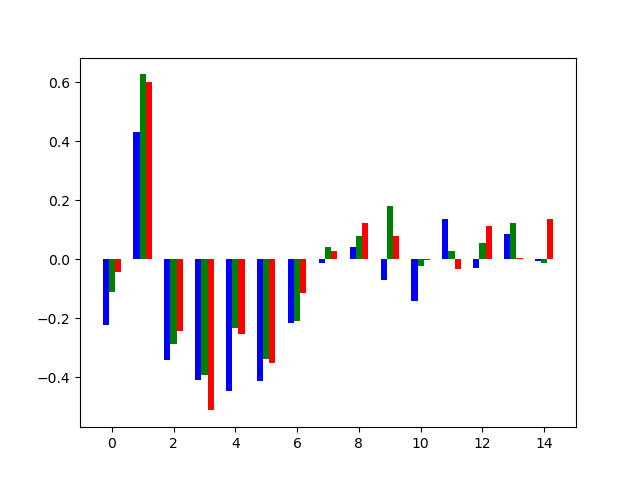

In [240]:
non_strategic_model.normalize_weights()
strategic_model_naive.normalize_weights()
strategic_model_man.normalize_weights()


print(non_strategic_model.b)
print(strategic_model_naive.b)
print(strategic_model_man.b)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(torch.arange(15)-0.2, non_strategic_model.w.detach(), width=0.2, color='b', align='center')
ax.bar(torch.arange(15), strategic_model_naive.w.detach(), width=0.2, color='g', align='center')
ax.bar(torch.arange(15)+0.2, strategic_model_man.w.detach(), width=0.2, color='r', align='center')
plt.show()